In [2]:
# load package
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time

In [3]:
# load package
from plotly.offline import iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline
# 進度條工具
from ipywidgets import IntProgress
from IPython.display import display

In [4]:
# 分配顯存空間，未使用 tensorflow-GPU 可以跳過這段
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [5]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Flatten, RepeatVector, Activation
from keras.layers import SimpleRNN, LSTM, CuDNNLSTM, CuDNNGRU
from keras.layers import Dropout, BatchNormalization, Bidirectional
from keras import optimizers, regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model

### Sub：Metrics
---

In [5]:
# Metrics
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def calcError(origin, forecast):
    print("RMSE", RMSE(origin, forecast))
    print("MAPE", MAPE(origin, forecast))

In [6]:
def showPlot(true, prediction, title, sub_title, size='M', save=False):
    # 列印績效圖表，可以選擇是否儲存
    size == 'L' and plt.figure(figsize=(28, 10))
    plt.plot(true, color='red', label='Real')
    plt.plot(prediction, color='blue', label='Prediction')
    plt.title('Industry Elec Prediction %s %s t:%d' % (title, sub_title, time))
    plt.xlabel('Time')
    plt.ylabel('kW')
    plt.legend()
    save and plt.savefig('Image/%s-%s-%d.png' % (title, sub_title, time))
    plt.show()

In [7]:
def showModelLoss(history, startFrom=10):
    plt.plot(history.history['loss'][startFrom:], label = 'loss')
    plt.plot(history.history['val_loss'][startFrom:], color = 'red', label = 'val_loss')
    plt.legend()
    plt.show()

### Sub：Data Processing
---

In [8]:
def augFeatures(data, features_select): # 資料特徵擷取
    data = pd.DataFrame(data[features_select])
    return data

In [9]:
def fitNormalize(data, trainTo): # 計算正規化倍率
    # 獲得訓練資料的尾端
    num_train_to = df[df['Date'] == trainTo].index.item() + 1
    trainData = pd.DataFrame(data[:num_train_to])
    # 僅使用資訓練資料計算正歸化倍率
    sc = MinMaxScaler(feature_range=(0, 1))
    sc.fit_transform(trainData)
    data_scaled = doNormalize(sc, data)
    return sc, data_scaled

def doNormalize(sc, data): # 正規化
    data_scaled = pd.DataFrame(sc.transform(data))
    return data_scaled

def deNormalize(sc, value): # 還原尺度
    value_unscaled = value * \
        (sc.data_max_[0]-sc.data_min_[0]) + sc.data_min_[0]
    value_unscaled = value_unscaled.reshape(value_unscaled.shape[0])
    return value_unscaled

In [10]:
# 根據給定的時間範圍自動產生訓練集
def split_train(data, trainFrom, trainTo, pastDay=7, futureDay=7):
    num_train_from = df[df['Date'] == trainFrom].index.item()
    num_train_to = df[df['Date'] == trainTo].index.item() + 1
    RawTrain = data[num_train_from:num_train_to]
    # print('RawTrain', RawTrain.shape)
    return RawTrain
# 根據給定的時間範圍自動產生測試集
def split_test(data, testFrom, testTo, pastDay=7, futureDay=7):
    num_test_from = df[df['Date'] == testFrom].index.item()
    num_test_to = df[df['Date'] == testTo].index.item() + 1
    RawTest = data[num_test_from-pastDay:num_test_to]
    # print('RawTest', RawTest.shape)
    return RawTest
# 拆分訓練與驗證，需要手動切割時才使用
def split_val(X, Y, rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

In [11]:
def buildTrain(train, pastDay, futureDay): # 滾動訓練資料
    X_train, Y_train = [], []
    for i in range(pastDay, len(train)-futureDay):
        X_train.append(train[i-pastDay:i])
        Y_train.append(train[i:i+futureDay, 0])  # kW
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    return X_train, Y_train

In [12]:
def buildTest(test, pastDay, futureDay): # 滾動測試資料
    input_set, truth_set = test, test[pastDay:]
    X_test, Y_truth = [], []
    for i in range(0, int((test.shape[0]-pastDay)/futureDay)):
        X_test.append(input_set[futureDay*i:futureDay*i+pastDay])
        Y_truth.append(truth_set[i*futureDay:(i+1)*futureDay, 0])  # kW
    testInput, testTruth = np.array(X_test), np.array(Y_truth)
    testInput = testInput.reshape(testInput.shape[0], testInput.shape[1], testInput.shape[2])
    testTruth = testTruth.reshape(testTruth.shape[0] * testTruth.shape[1])
    # print('testInput.shape, testTruth.shape', testInput.shape, testTruth.shape)
    return testInput, testTruth

### Sub：Peak Load
---

In [13]:
# 定義 PeakLoad 相關參數
pl_features = [
    'PeakLoad(MW)',
    'isHoliday_shift7',
    'dayOfYear',
    'weekUpdate_shift7',
    'Temp_Taipei_shift7',
]

weekCutList = ['MON/SUN', 'TUE/MON', 'WED/TUE',
               'THU/WED', 'FRI/THU', 'SAT/FRI', 'SUN/SAT']
# +7(shift)
weekCut_from_to = [{'from': '2019-01-07',
                    'to': '2019-10-06'},
                   {'from': '2019-01-01',
                    'to': '2019-10-07'},
                   {'from': '2019-01-02',
                    'to': '2019-10-01'},
                   {'from': '2019-01-03',
                    'to': '2019-10-02'},
                   {'from': '2019-01-04',
                    'to': '2019-10-03'},
                   {'from': '2019-01-05',
                    'to': '2019-10-04'},
                   {'from': '2019-01-06',
                    'to': '2019-10-05'}]

In [14]:
def loadPeakLoadModel():
    p = IntProgress()
    display(p)
    model_list = []
    for i in range(10):
        p.value += 10
        p.description = 'load %d/%d'%((i+1), 10)
        model = load_model('Model/PeakLoad/PeakLoad_%d_%d.h5' % (1, i))
        model_list.append(model)
    return model_list

In [15]:
def replacePeakLoad(weekCut_Text, RawData): # 替換尖峰負載
    weekCut = weekCutList.index(weekCut_Text)
    pl_RawData = augFeatures(df, pl_features)
    pl_sc, pl_RawData_n = fitNormalize(pl_RawData, trainTo)
    df_shift = forecastPeakLoad(weekCut, pl_RawData_n, pl_sc)
    df_index = df[df['Date'] == '2019-09-30'].index.item() + 1 
    RawData['PeakLoad(MW)_shift7'] = df_shift[:df_index]
    return RawData

In [16]:
def forecastPeakLoad(weekCut, RawData, sc): # 預測尖峰負載 & shift
    print("- PeakLoad %s" % (weekCutList[weekCut]))
    # 將'PeakLoad(MW)_shift7'還原為初始狀態(shift前、真實值)
    df_shift = df.copy()
    df_shift['PeakLoad(MW)_shift7'] = df_shift['PeakLoad(MW)']
    weekCut_range = (df_shift['Date'] >= weekCut_from_to[weekCut].get('from')) & (
        df_shift['Date'] <= weekCut_from_to[weekCut].get('to'))
    # 執行預測
    weekCutRaw = split_test(RawData,
                            weekCut_from_to[weekCut].get('from'),
                            weekCut_from_to[weekCut].get('to'),
                            pastDay, futureDay)
    weekCutInput, weekCutTruth = buildTest(
        weekCutRaw.values, pastDay, futureDay)
    weekCutPredict = []
    for j in range(10):
        temp = model_evaluate(pl_model[j], sc, weekCutTruth, weekCutInput)
        weekCutPredict.append(temp.reshape(temp.shape[0]))
    weekCutPredict = np.array(weekCutPredict).mean(axis=0)
    df_shift.at[df_shift[weekCut_range].index.tolist(
    ), 'PeakLoad(MW)_shift7'] = weekCutPredict
    # 檢視替換後的績效
    df_weekCut = df_shift[weekCut_range]
    calcError(df_weekCut['PeakLoad(MW)'], df_weekCut['PeakLoad(MW)_shift7'])
    # shift7 then return
    df_shift['PeakLoad(MW)_shift7'] = df_shift['PeakLoad(MW)_shift7'].shift(-7, axis=0)
    return df_shift['PeakLoad(MW)_shift7']

### Sub：Model
---

In [17]:
def buildModel(shape, train_x, train_y):
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
#     L2 = regularizers.l2(0.01)
    
    epochs, batch_size = 1000, 16
    model = Sequential()
    model.add(CuDNNGRU(units=200, input_shape=(shape[1], shape[2])))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
    model.add(RepeatVector(futureDay)) # futureDay = 7
    
    model.add(CuDNNGRU(200, return_sequences=True))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.1))

#     model.add(SimpleRNN(50, kernel_regularizer=L2, return_sequences=True))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.1))
    
    model.add(TimeDistributed(Dense(200, activation='relu')))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.1))
    model.add(TimeDistributed(Dense(1)))

    model.compile(loss='mse', optimizer='adam')
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.3, patience=30, mode='min', verbose=0)
    earlyStop = EarlyStopping(
        monitor="val_loss", patience=150, mode="min", restore_best_weights=True)
    modelResult = model.fit(train_x, train_y,
                            epochs=epochs, batch_size=batch_size,
                            verbose=0,
                            validation_split=0.1,
                            callbacks=[reduce_lr, earlyStop])
    return model, modelResult

In [18]:
def model_forecast(model, input_data):
    forecast_temp = model.predict(input_data)
    forecast = forecast_temp.reshape(
        forecast_temp.shape[0] * forecast_temp.shape[1])
    return forecast

In [19]:
def model_evaluate(model, sc, truth, input_set):
    truth = pd.DataFrame(truth)
    truth = deNormalize(sc, truth.values)
    predict = model_forecast(model, input_set)
    predict = deNormalize(sc, predict)
    return predict

### Main
---

In [20]:
%%time
# load peak load model
pl_model = loadPeakLoadModel()

IntProgress(value=0)


Wall time: 19.4 s


In [21]:
# 預測時間
trainFrom = '2017-01-05' #(四~三)
trainTo = '2018-12-26'
testFrom = '2019-01-06' #(日~六)
testTo = '2019-09-28'
# 步數選擇
pastDay = 7
futureDay = 7
# 定義特徵
kw_features = [
    'kW',
    'PeakLoad(MW)_shift7',
#     'PeakLoad(MW)',
    'isHoliday_shift7',
    'dayOfYear',
    'weekUpdate_shift7',
    'Temp_Taipei_shift7',
]

In [22]:
# 資料讀入
df = pd.read_csv('Data/IndustryElec_processed_20160101_20190930.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.shape

(1461, 13)

In [24]:
# 特徵選取
RawData = augFeatures(df, kw_features)
# 使用預測的尖峰負載替換 'PeakLoad(MW)_shift7'
RawData = replacePeakLoad('WED/TUE' ,RawData)

- PeakLoad WED/TUE
RMSE 797.8181518977129
MAPE 1.8957373247334566


In [26]:
# 正規化
sc, RawData_n = fitNormalize(RawData, trainTo)

In [33]:
# 資料範圍選取
RawTrain = split_train(RawData_n, trainFrom, trainTo, pastDay, futureDay)
RawSelf = split_test(RawData_n, '2017-01-11', '2019-01-01', pastDay, futureDay)
RawTest = split_test(RawData_n, testFrom, testTo, pastDay, futureDay)

# 資料打包
X_train, Y_train = buildTrain(RawTrain.values, pastDay, futureDay)
selfInput, selfTruth = buildTest(RawSelf.values, pastDay, futureDay)
testInput, testTruth = buildTest(RawTest.values, pastDay, futureDay)

# 驗證資料
# X, Y, Xv, Yv= split_val(X_train, Y_train, 0.1)

round:  0


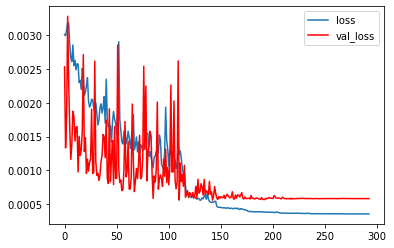

round:  1


In [ ]:
%%time
model_save= []

# 為求公平衡量模型，執行 n次
for i in range(15):
    print("round: ", str(i))
    model, modelResult = buildModel(X_train.shape, X_train, Y_train)
    model_save.append(model) # 儲存 model 供未來使用
    showModelLoss(modelResult, startFrom=20)

## Log Setting
##### ( 設定本次實驗的戳記代碼 )
---

In [ ]:
time = 1
# save = True
save = False
# model_name = '(RNN_with_BN)'
model_name = '(RNN_L1L2_5)'

## Prediction
---

In [ ]:
total_self = []
total_test = []

# 為求公平衡量模型，執行 n次
for i in range(15):
    print("round: ", str(i))
    self_predict = model_evaluate(model_save[i], sc, selfTruth, selfInput)
    test_predict = model_evaluate(model_save[i], sc, testTruth, testInput)
    total_self.append(self_predict.reshape(self_predict.shape[0]))
    total_test.append(test_predict.reshape(test_predict.shape[0]))
    
# 平均處理 n個模型的預測結果
mean_self = np.array(total_self).mean(axis=0)
mean_test = np.array(total_test).mean(axis=0)

In [ ]:
# 自我測試( 使用訓練資料進行預測，檢查是否過度學習 )
self_trurh = pd.DataFrame(selfTruth)
self_trurh = deNormalize(sc, self_trurh.values)
calcError(self_trurh, mean_self)
showPlot(self_trurh, mean_self, model_name, "self", size="L", save=save)

In [ ]:
# 實際測試
test_trurh = pd.DataFrame(testTruth)
test_trurh = deNormalize(sc, test_trurh.values)
calcError(test_trurh, mean_test)
showPlot(test_trurh, mean_test, model_name, str(len(testTruth)), save=save)

## 特殊日替換
---

In [ ]:
# 建構物件
num_test_from = df[df['Date'] == testFrom].index.item()
num_test_to = df[df['Date'] == testTo].index.item() + 1
d = {'date': pd.date_range(start = testFrom, end = testTo),
     'week': df[num_test_from:num_test_to]['week'].values,
     'isHoliday': df[num_test_from:num_test_to]['isHoliday'].values,
     'truth': test_trurh,
     'rowsMean': mean_test}
df_predict = pd.DataFrame(d)
df_predict.shape

In [ ]:
# 定義特殊日
_0202_0210 = (df_predict['date'] >=
              '2019-02-02') & (df_predict['date'] <= '2019-02-10')
_0228_0303 = (df_predict['date'] >=
              '2019-02-28') & (df_predict['date'] <= '2019-03-03')
_0404_0407 = (df_predict['date'] >=
              '2019-04-04') & (df_predict['date'] <= '2019-04-07')
_0501 = (df_predict['date'] >=
         '2019-05-01') & (df_predict['date'] <= '2019-05-01')
_0607_0609 = (df_predict['date'] >=
              '2019-06-07') & (df_predict['date'] <= '2019-06-09')
_0913_0915 = (df_predict['date'] >=
              '2019-09-13') & (df_predict['date'] <= '2019-09-15')

holidays = ['春節 (SAT/FRI)', '228假期 (THU/WED)', '清明假期 (THU/WED)', 
            '勞動節 (WED/TUE)', '端午假期 (FRI/THU)', '中秋假期 (FRI/THU)']

holiday_weekCut = ['SAT/FRI', 'THU/WED',
                   'THU/WED', 'WED/TUE', 'FRI/THU', 'FRI/THU']

holiday_range = [_0202_0210, _0228_0303,
                 _0404_0407, _0501, _0607_0609, _0913_0915]

holiday_from_to = [{'from': '2019-02-02',
                    'to': '2019-02-15'},
                   {'from': '2019-02-28',
                       'to': '2019-03-07'},
                   {'from': '2019-04-04',
                       'to': '2019-04-11'},
                   {'from': '2019-05-01',
                       'to': '2019-05-08'},
                   {'from': '2019-06-07',
                       'to': '2019-06-14'},
                   {'from': '2019-09-13',
                       'to': '2019-09-20'}]

holiday_len = [9, 4, 4, 1, 3, 3]

In [ ]:
# 觀察特殊日績效
for i in range(len(holidays)):
    df_temp = df_predict[holiday_range[i]]
    print("%s %d days"%(holidays[i] ,len(df_temp)))
    calcError(df_temp['truth'], df_temp['rowsMean'])

print("沒有排除特殊日（原始績效）")
calcError(df_predict['truth'], df_predict['rowsMean'])

print("排除所有特殊日")
excludeSpecialdays = ~_0202_0210 & ~_0228_0303 & ~_0404_0407 & ~_0501 & ~_0607_0609 & ~_0913_0915
df_excludeSpecialdays = df_predict[excludeSpecialdays]
calcError(df_excludeSpecialdays['truth'], df_excludeSpecialdays['rowsMean'])

print("平日(特殊日)")
df_excludeHolidays = df_predict[df_predict['isHoliday']==False]
calcError(df_excludeHolidays['truth'], df_excludeHolidays['rowsMean'])

print("假日(特殊日)")
df_excludeNormaldays = df_predict[df_predict['isHoliday']==True]
calcError(df_excludeNormaldays['truth'], df_excludeNormaldays['rowsMean'])

print("平日")
df_exclude = df_predict[df_predict['week']<6]
calcError(df_exclude['truth'], df_exclude['rowsMean'])

print("假日")
df_exclude = df_predict[df_predict['week']>=6]
calcError(df_exclude['truth'], df_exclude['rowsMean'])

In [ ]:
# 替換特殊日
df_update = df_predict

for i in range(len(holidays)):
    print("\n%s" % (holidays[i]))
    # 選取要重新預測的期間
    RawData = replacePeakLoad(holiday_weekCut[i] ,RawData) # 使用預測的尖峰負載替換 'PeakLoad(MW)_shift7'
    RawData_n = doNormalize(sc, RawData)
    holidayRaw = split_test(RawData_n,
                            holiday_from_to[i].get('from'),
                            holiday_from_to[i].get('to'),
                            pastDay, futureDay)
    holidayInput, holidayTruth = buildTest(
        holidayRaw.values, pastDay, futureDay)
    # 特殊日的替換也要使用 10 個 model 預測後取平均
    holidayPredict = []
    for j in range(30):
        temp = model_evaluate(model_save[j], sc, holidayTruth, holidayInput)
        holidayPredict.append(temp.reshape(temp.shape[0]))
    holidayPredict = np.array(holidayPredict).mean(axis=0)

    df_update.at[df_update[holiday_range[i]].index.tolist(),
                 'rowsMean'] = holidayPredict[:holiday_len[i]]
    # 計算替換後的績效
    df_holiday = df_update[holiday_range[i]]
    print('- Holiday')
    calcError(df_holiday['truth'], df_holiday['rowsMean'])

In [ ]:
truth = df_update['truth']
pred = df_update['rowsMean']
calcError(truth, pred)
showPlot(truth, pred, model_name, str(len(truth))+'-update', save=save)

## Save Model
---

In [ ]:
# import h5py
# Model.save('Model/IndustryElec_cLSTM(7to7)_model_%d.h5'%(time))